<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/PET_Correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import pydicom" || pip install pydicom
!python -c "import dicom2nifti" ||pip install dicom2nifti



from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
from google.colab import drive
import os

import dicom2nifti


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 1.5 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pydicom'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'dicom2nifti'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 20.7 MB/s eta 0:00:00


## Set dataset path

In [13]:
# from google.colab import drive
# import zipfile
# import os

# drive.mount('/content/drive')

# root_dir = '/content/drive/My Drive/PET_data'
# zip_file_path = os.path.join(root_dir, 'pet.zip')
# extracted_folder_path = os.path.join(root_dir, 'sapmle_data')

# # Create the extracted data folder if it doesn't exist
# os.makedirs(extracted_folder_path, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_folder_path)

# # List the contents of each patient folder, including subfolders
# for patient_folder in os.listdir(extracted_folder_path):
#     patient_folder_path = os.path.join(extracted_folder_path, patient_folder)

#     # List subfolders within the patient folder
#     subfolders = [subfolder for subfolder in os.listdir(patient_folder_path) if os.path.isdir(os.path.join(patient_folder_path, subfolder))]

#     print(f"Contents of {patient_folder}: {subfolders}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of P010: ['MAC', 'NAC']
Contents of P001: ['MAC', 'NAC']
Contents of P002: ['MAC', 'NAC']
Contents of P003: ['MAC', 'NAC']
Contents of P004: ['MAC', 'NAC']
Contents of P005: ['MAC', 'NAC']
Contents of P006: ['MAC', 'NAC']
Contents of P007: ['MAC', 'NAC']
Contents of P008: ['MAC', 'NAC']
Contents of P009: ['MAC', 'NAC']


In [2]:
def dicom_to_nifti(dicom_folder, output_folder):
    print(f"Converting DICOM files from {dicom_folder} to NIfTI files in {output_folder}")
    # Convert DICOM to NIfTI
    dicom2nifti.convert_directory(dicom_folder, os.path.join(output_folder), compression=True, reorient=True)
    print("Conversion complete.")


In [3]:
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/PET_data/sample_data'

# Create folders for MAC and NAC NIfTI files at the root level
output_folder_mac = os.path.join(root_dir, "MAC")
output_folder_nac = os.path.join(root_dir, "NAC")
os.makedirs(output_folder_mac, exist_ok=True)
os.makedirs(output_folder_nac, exist_ok=True)
patient_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])

for patient_folder in patient_folders:
    dicom_folder = root_dir + "/" + patient_folder + "/MAC"
    output_folder = root_dir + "/MAC"
    dicom_to_nifti(dicom_folder, output_folder)

    dicom_folder = root_dir + "/" + patient_folder + "/NAC"
    output_folder = root_dir + "/" + patient_folder
    dicom_to_nifti(dicom_folder, output_folder)

Mounted at /content/drive
Converting DICOM files from /content/drive/My Drive/PET_data/sample_data/MAC/MAC to NIfTI files in /content/drive/My Drive/PET_data/sample_data/MAC
Conversion complete.
Converting DICOM files from /content/drive/My Drive/PET_data/sample_data/MAC/NAC to NIfTI files in /content/drive/My Drive/PET_data/sample_data/MAC
Conversion complete.
Converting DICOM files from /content/drive/My Drive/PET_data/sample_data/MAC_nifti_root/MAC to NIfTI files in /content/drive/My Drive/PET_data/sample_data/MAC
Conversion complete.
Converting DICOM files from /content/drive/My Drive/PET_data/sample_data/MAC_nifti_root/NAC to NIfTI files in /content/drive/My Drive/PET_data/sample_data/MAC_nifti_root
Conversion complete.
Converting DICOM files from /content/drive/My Drive/PET_data/sample_data/NAC/MAC to NIfTI files in /content/drive/My Drive/PET_data/sample_data/MAC
Conversion complete.
Converting DICOM files from /content/drive/My Drive/PET_data/sample_data/NAC/NAC to NIfTI files 

In [4]:
import shutil
nac_folder = os.path.join(root_dir, "NAC_nifti")
mac_folder = os.path.join(root_dir, "MAC_nifti")

# Create NAC folder if it doesn't exist
os.makedirs(nac_folder, exist_ok=True)
os.makedirs(mac_folder, exist_ok=True)

# Iterate through patient folders
for patient_folder in os.listdir(root_dir):
    patient_folder_path = os.path.join(root_dir, patient_folder)

    # Check if it's a directory
    if os.path.isdir(patient_folder_path):
        # Locate the "5_pet_wb_uncorrected.nii" file
        file_path1 = os.path.join(patient_folder_path, "5_pet_wb_uncorrected.nii.gz")
        file_path2 = os.path.join(patient_folder_path, "4_pet_wb_hd.nii.gz")

        # Check if the file exists
        if os.path.isfile(file_path1):
            # Generate the new file name based on the patient folder name
            new_file_name = f"{patient_folder}.nii.gz"

            # Move and rename the file to the NAC folder
            new_file_path = os.path.join(nac_folder, new_file_name)
            shutil.copy(file_path1, new_file_path)

            print(f"Moved and renamed: {new_file_path}")

        if os.path.isfile(file_path2):
            # Generate the new file name based on the patient folder name
            new_file_name = f"{patient_folder}.nii.gz"

            # Move and rename the file to the NAC folder
            new_file_path = os.path.join(mac_folder, new_file_name)
            shutil.copy(file_path2, new_file_path)

            print(f"Moved and renamed: {new_file_path}")

Moved and renamed: /content/drive/My Drive/PET_data/sample_data/NAC_nifti/P010.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/MAC_nifti/P010.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/NAC_nifti/P001.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/MAC_nifti/P001.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/NAC_nifti/P002.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/MAC_nifti/P002.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/NAC_nifti/P003.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/MAC_nifti/P003.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/NAC_nifti/P004.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/MAC_nifti/P004.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sample_data/NAC_nifti/P005.nii.gz
Moved and renamed: /content/drive/My Drive/PET_data/sa

In [6]:

train_images = sorted(glob.glob(os.path.join(root_dir, "NAC_nifti", "*.nii.gz")))
data_dicts = [{"image": img, "target": img} for img in train_images]
# making  smaller input to save time for practing stage:
train_files, val_files = data_dicts[-1:], data_dicts[-1:]

set_determinism(seed=0)


In [7]:
### First method

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(
            keys=["image", "target"],
            a_min=-1024,
            a_max=2048,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "target"],
            label_key="target",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(
            keys=["image", "target"],
            a_min=-1024,
            a_max=2048,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

train_ds = CacheDataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 1/1 [00:22<00:00, 22.53s/it]


image shape: torch.Size([454, 454, 434]), target shape: torch.Size([454, 454, 434])


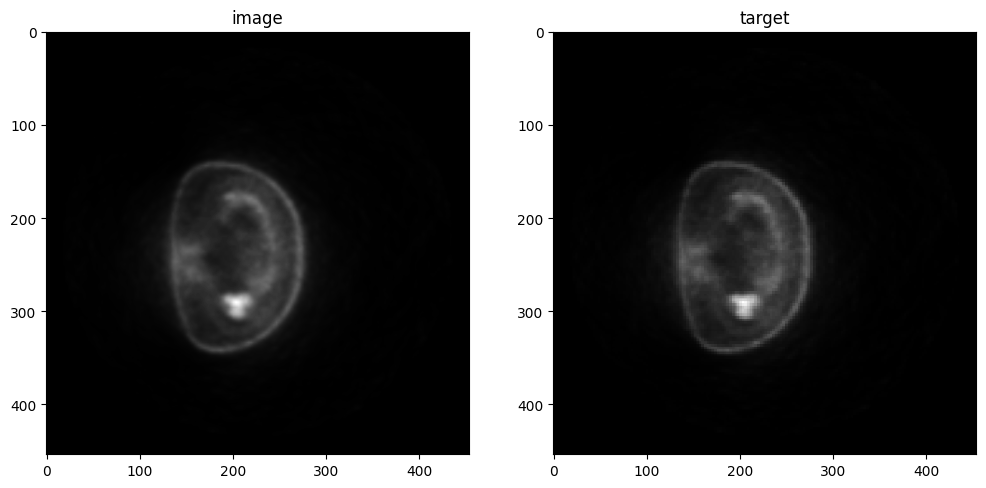

In [10]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 200

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n], cmap= "gray")
plt.show()